In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Нестационарный ряд
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
# Стационарный ряд
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [3]:
all_series = {
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Daily total female births in California": female_births["Count"]
}

In [4]:
all_series

{'International airline passengers: monthly totals in thousands': 0      112
 1      118
 2      132
 3      129
 4      121
       ... 
 139    606
 140    508
 141    461
 142    390
 143    432
 Name: Count, Length: 144, dtype: int64,
 'Daily total female births in California': 0      35
 1      32
 2      30
 3      31
 4      44
        ..
 360    37
 361    52
 362    48
 363    55
 364    50
 Name: Count, Length: 365, dtype: int64}

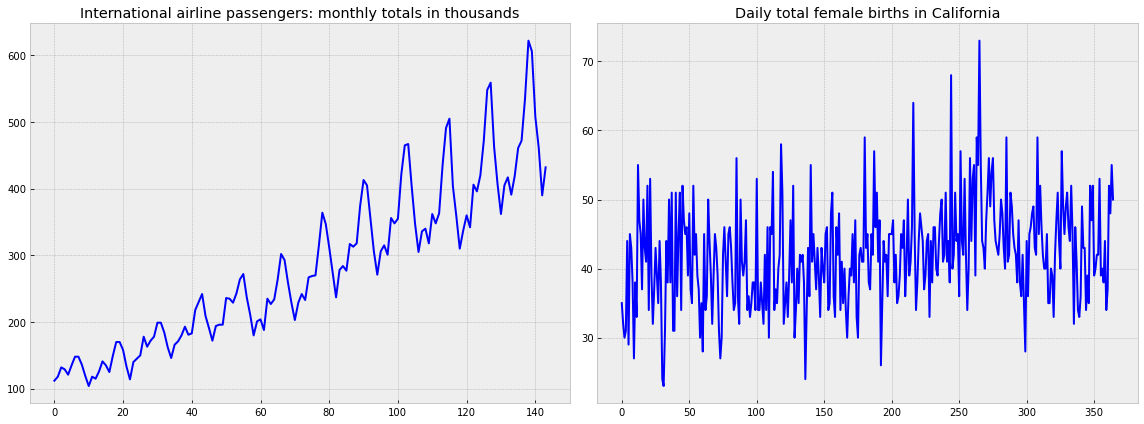

In [5]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 6))
    layout = (1, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

1. Построим прогноз для нестационарного ряда

In [6]:
# Ряд airlines_passengers не является стационарным и обладает выраженной сезонностью, поэтому мы можем применить
# к нему тройное экспоненциальное сглаживание (метод Хольта-Винтерса)
series = airlines_passengers["Count"]

In [7]:
train, test, val = series[:60], series[60:100], series[100:]

In [8]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [9]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [10]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [11]:
def plot_tema(alpha, beta, gamma, ser=airlines_passengers["Count"], ser_to_plot=airlines_passengers["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

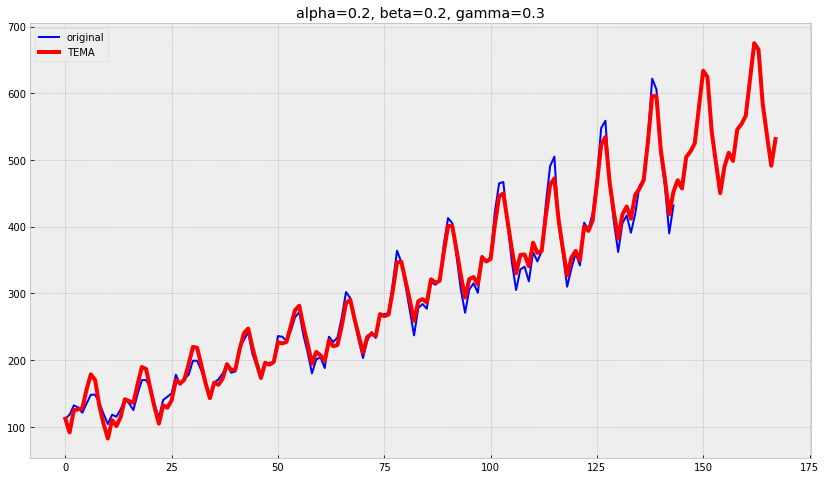

In [12]:
plot_tema(0.2, 0.2, 0.3)

In [13]:
# Произведем подбор параметров
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [14]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [15]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 431.64211168317604
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.18935997e-02, -6.94751631e+00,  2.04636308e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 368
      nit: 57
     njev: 92
   status: 0
  success: True
        x: array([0.00229008, 1.        , 0.28037163])


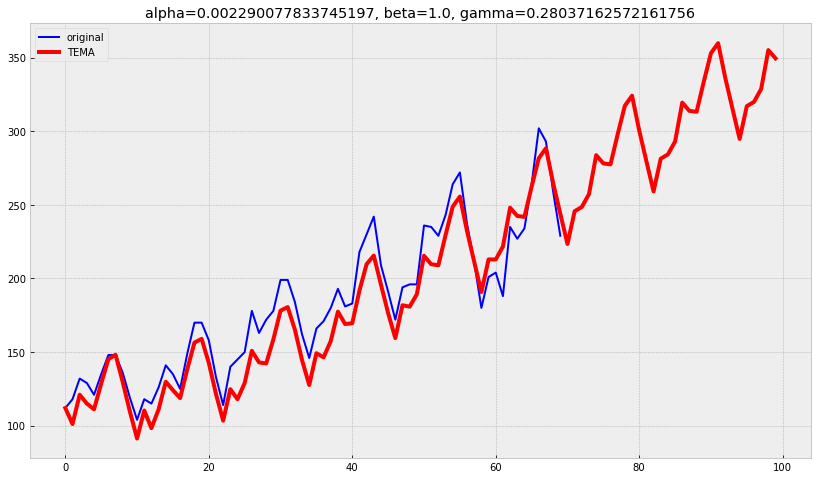

In [16]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

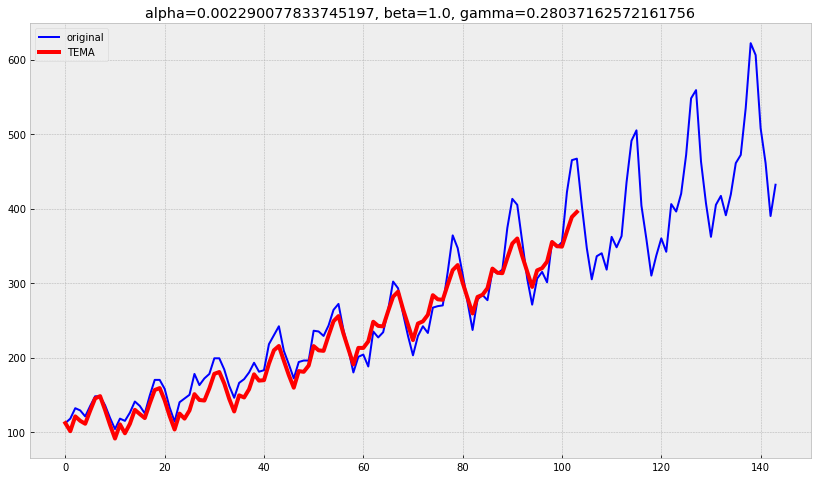

In [17]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:60], ser_to_plot=series, n_preds=len(val))

In [18]:
# Кросс-валидация
train, val = series[:120], series[120:]

In [19]:
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [20]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

32536.802831485646------------
32536.785167228343------------
32536.80283148565------------
32536.801395702216------------
2808.3128444612416------------
2808.312838770578------------
2808.3113898219904------------
2808.3128444612416------------
5486.63627305624------------
5486.63625036358------------
5486.636923950674------------
5486.63627305624------------
2282.7814386943046------------
2282.781426612443------------
2282.7817124025023------------
2282.7814386943046------------
2187.812060285447------------
2187.81207153415------------
2187.812266940304------------
2187.812060285142------------
2159.8635945382994------------
2159.863602721825------------
2159.863332425771------------
2159.863594536197------------
2110.1900871709504------------
2110.1900971672817------------
2110.190156944453------------
2110.1900871710695------------
2104.0602669258183------------
2104.060276182406------------
2104.0602309771343------------
2104.0602669251116------------
2102.2978843543287----------

In [21]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 472.63483979701186
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.46744855e-04,  2.21689334e-04, -4.33560670e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 188
      nit: 31
     njev: 47
   status: 0
  success: True
        x: array([0.07229088, 0.10162817, 1.        ])


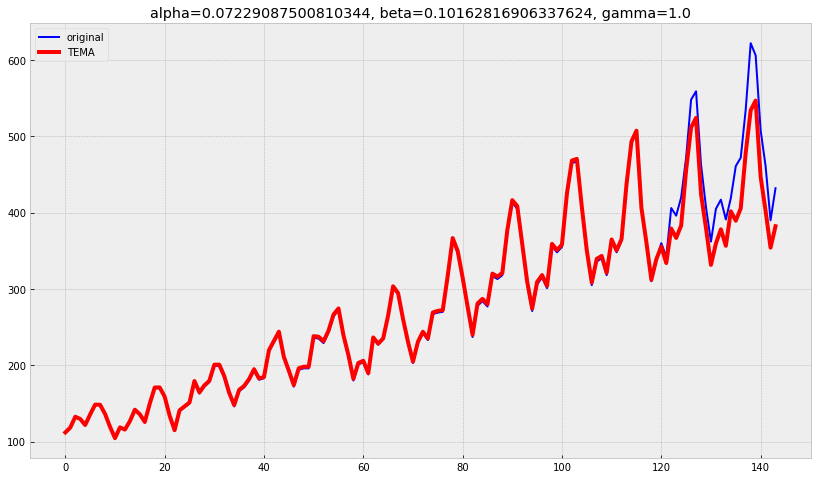

In [22]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

2. Построим прогноз для стационарного ряда

In [23]:
# Ряд female_births является стационарным и не обладает сезонностью, поэтому мы можем применить
# к нему метод экспоненциального сглаживания
series = female_births["Count"]

In [24]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [25]:
ema = exponential_moving_average(female_births["Count"], 0.2)

In [26]:
len(ema)

365

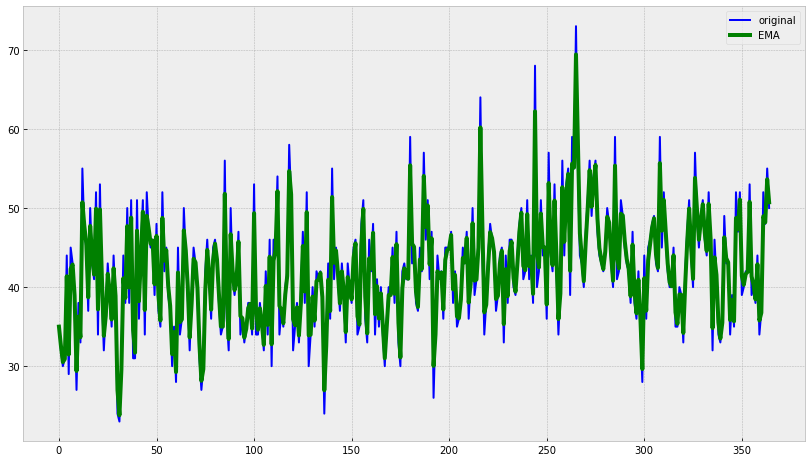

In [27]:
ema = exponential_moving_average(female_births["Count"], 0.8)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='original')
    plt.plot(ema, color='green', linewidth='4', label='EMA')
    plt.legend()

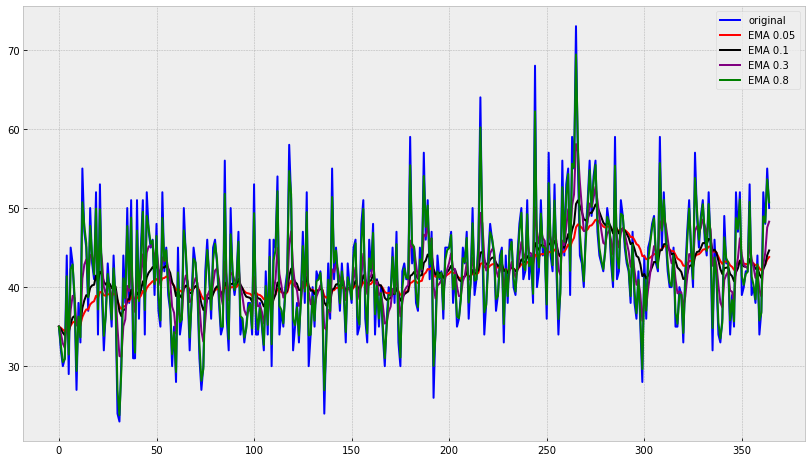

In [28]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'black', 'purple', 'green']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(female_births["Count"], alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

In [29]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

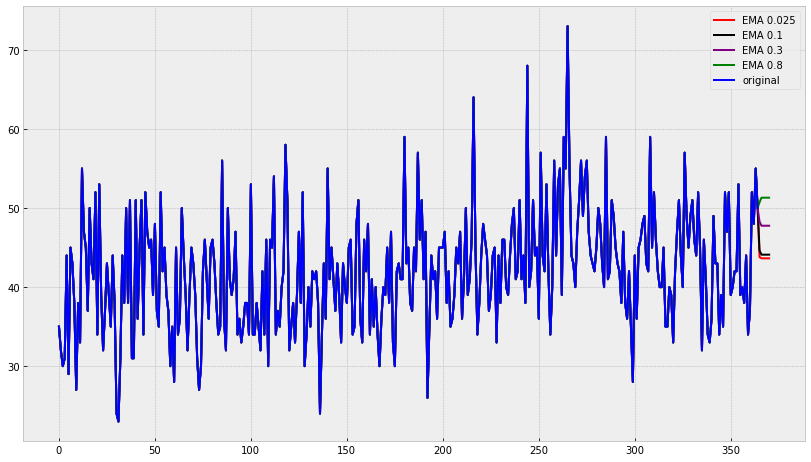

In [30]:
alphas = [0.025,0.1,0.3,0.8]
colors = ['red', 'black', 'purple', 'green']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = exponential_moving_average(female_births["Count"], alphas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(female_births["Count"], color='blue',label='original')
    plt.legend()

In [31]:
# Подбор параметров
series1 = female_births["Count"]

In [32]:
train1, test1, val1 = series1[:130], series1[130:170], series1[170:]

In [33]:
def mse(X1):
    alpha1 = X1
    result1 = exponential_moving_average(train1, alpha1)
    predictions1 = result1[-len(test1):]
    error1 = mean_squared_error(predictions1, test1)
    return error1

In [34]:
opt = minimize(mse, x0=0, method="L-BFGS-B")

In [35]:
alpha_opt = opt.x
print(opt)

      fun: 34.935982505745876
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.42108547e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 38
      nit: 8
     njev: 19
   status: 0
  success: True
        x: array([0.02497727])
